In [5]:
import time
import logging
import json
import numpy as np
import matplotlib.pyplot as plt
from binance.lib.utils import config_logging
from binance.websocket.spot.websocket_stream import SpotWebsocketStreamClient as Client

In [2]:
# lob-stream
config_logging(logging, logging.DEBUG)

storage = dict()
storage["orderbooks"] = []

def message_handler(_, message):
    message = json.loads(message)
    print(message["lastUpdateId"])
    ob = dict()
    ob["id"] = message["lastUpdateId"]
    ob["bids"] = [[float(i),float(j)] for [i,j] in message["bids"]]
    ob["asks"] = [[float(i),float(j)] for [i,j] in message["asks"]]
    storage["orderbooks"].append(ob)

my_client = Client(on_message=message_handler)

my_client.partial_book_depth(
    symbol="BTCUSDT",
    level=20,
    speed=100,
)

time.sleep(2)

logging.debug("closing ws connection")

my_client.stop()

with open("./data/orderbooks.json", "w") as file:
    json.dump(storage, file)


2024-03-06 20:24:20.448 UTC DEBUG binance.websocket.websocket_client: Creating connection with WebSocket Server: wss://stream.binance.com:9443/ws, proxies: {}
2024-03-06 20:24:21.962 UTC DEBUG binance.websocket.websocket_client: WebSocket connection has been established: wss://stream.binance.com:9443/ws, proxies: {}
2024-03-06 20:24:21.963 UTC DEBUG binance.websocket.websocket_client: Binance WebSocket Client started.
2024-03-06 20:24:21.964 UTC DEBUG binance.websocket.websocket_client: Sending message to Binance WebSocket Server: {"method": "SUBSCRIBE", "params": ["btcusdt@depth20@100ms"], "id": 1709756661964}
2024-03-06 20:24:22.322 UTC ERROR binance.websocket.websocket_client: Error from callback <function message_handler at 0x10b023a60>: 'lastUpdateId'


43974929944
43974929973
43974929994
43974930032
43974930093
43974930139
43974930162
43974930203
43974930221
43974930235
43974930253
43974930258
43974930276
43974930342
43974930379
43974930402


2024-03-06 20:24:23.968 UTC DEBUG root: closing ws connection


43974930440
43974930466
43974930478


2024-03-06 20:24:24.321 UTC WARNING binance.websocket.websocket_client: CLOSE frame received, closing websocket connection


43974930487


In [ ]:
# lob-analysis
import sortednp as snp

with open("./data/orderbooks.json", "r") as f:
    data = json.load(f)

book = data["orderbooks"][0]
id = book["id"]
bids = np.array(book["bids"])
bid_levels = bids[:,0]
bid_vols=bids[:,1]
asks = np.array(book["asks"])
ask_levels = asks[:,0]
ask_vols=asks[:,1]

levels = np.append(ask_levels,bid_levels)
vols=np.append(ask_vols,bid_vols)
plt.bar(levels,vols)
plt.show()

levels = np.array([])
vols = np.array([])

for book in data["orderbooks"]:
    bids = np.array(book["bids"])
    bid_levels = bids[:,0]
    bid_vols=bids[:,1]
    asks = np.array(book["asks"])
    ask_levels = asks[:,0]
    ask_vols=asks[:,1]

    levels = snp.merge(levels,bid_levels,duplicates=snp.DROP)
    levels = snp.merge(levels,ask_levels,duplicates=snp.DROP)

    vols = snp.merge(vols,bid_vols,duplicates=snp.DROP)
    vols = snp.merge(vols,ask_vols,duplicates=snp.DROP)

print(levels)
print(vols)

# need to write algorithm to merge two lists - should be doable in n^2


In [4]:
# trades
config_logging(logging, logging.DEBUG)

storage = dict()
storage["trades"] = []

def message_handler(_, message):
    message = json.loads(message)
    #print(message["lastUpdateId"])
    #ob = dict()
    #ob["id"] = message[0]["id"]
    trade = dict()
    trade["time"] = message["E"]
    trade["symbol"] = message["s"]
    trade["id"] = message["t"]
    trade["price"] = message["p"]
    trade["quantity"] = message["q"]
    trade["buyer order id"] = message["b"]
    trade["seller order id"] = message["a"]
    trade["buyer maker"] = message["m"]
    #print(message["e"])
    storage["trades"].append(trade)

my_client = Client(on_message=message_handler)

my_client.trade(symbol="btcusdt")

time.sleep(240)

logging.debug("closing ws connection")

my_client.stop()

with open("./data/trades.json", "w") as file:
    json.dump(storage, file)


2024-03-07 18:13:12.472 UTC DEBUG binance.websocket.websocket_client: Creating connection with WebSocket Server: wss://stream.binance.com:9443/ws, proxies: {}
2024-03-07 18:13:13.719 UTC DEBUG binance.websocket.websocket_client: WebSocket connection has been established: wss://stream.binance.com:9443/ws, proxies: {}
2024-03-07 18:13:13.721 UTC DEBUG binance.websocket.websocket_client: Binance WebSocket Client started.
2024-03-07 18:13:13.722 UTC DEBUG binance.websocket.websocket_client: Sending message to Binance WebSocket Server: {"method": "SUBSCRIBE", "params": ["btcusdt@trade"], "id": 1709835193722}
2024-03-07 18:13:14.055 UTC ERROR binance.websocket.websocket_client: Error from callback <function message_handler at 0x110be0cc0>: 'E'
2024-03-07 18:13:39.186 UTC DEBUG binance.websocket.websocket_client: Received Ping; PONG frame sent back
2024-03-07 18:16:39.208 UTC DEBUG binance.websocket.websocket_client: Received Ping; PONG frame sent back
2024-03-07 18:17:13.728 UTC DEBUG root: 

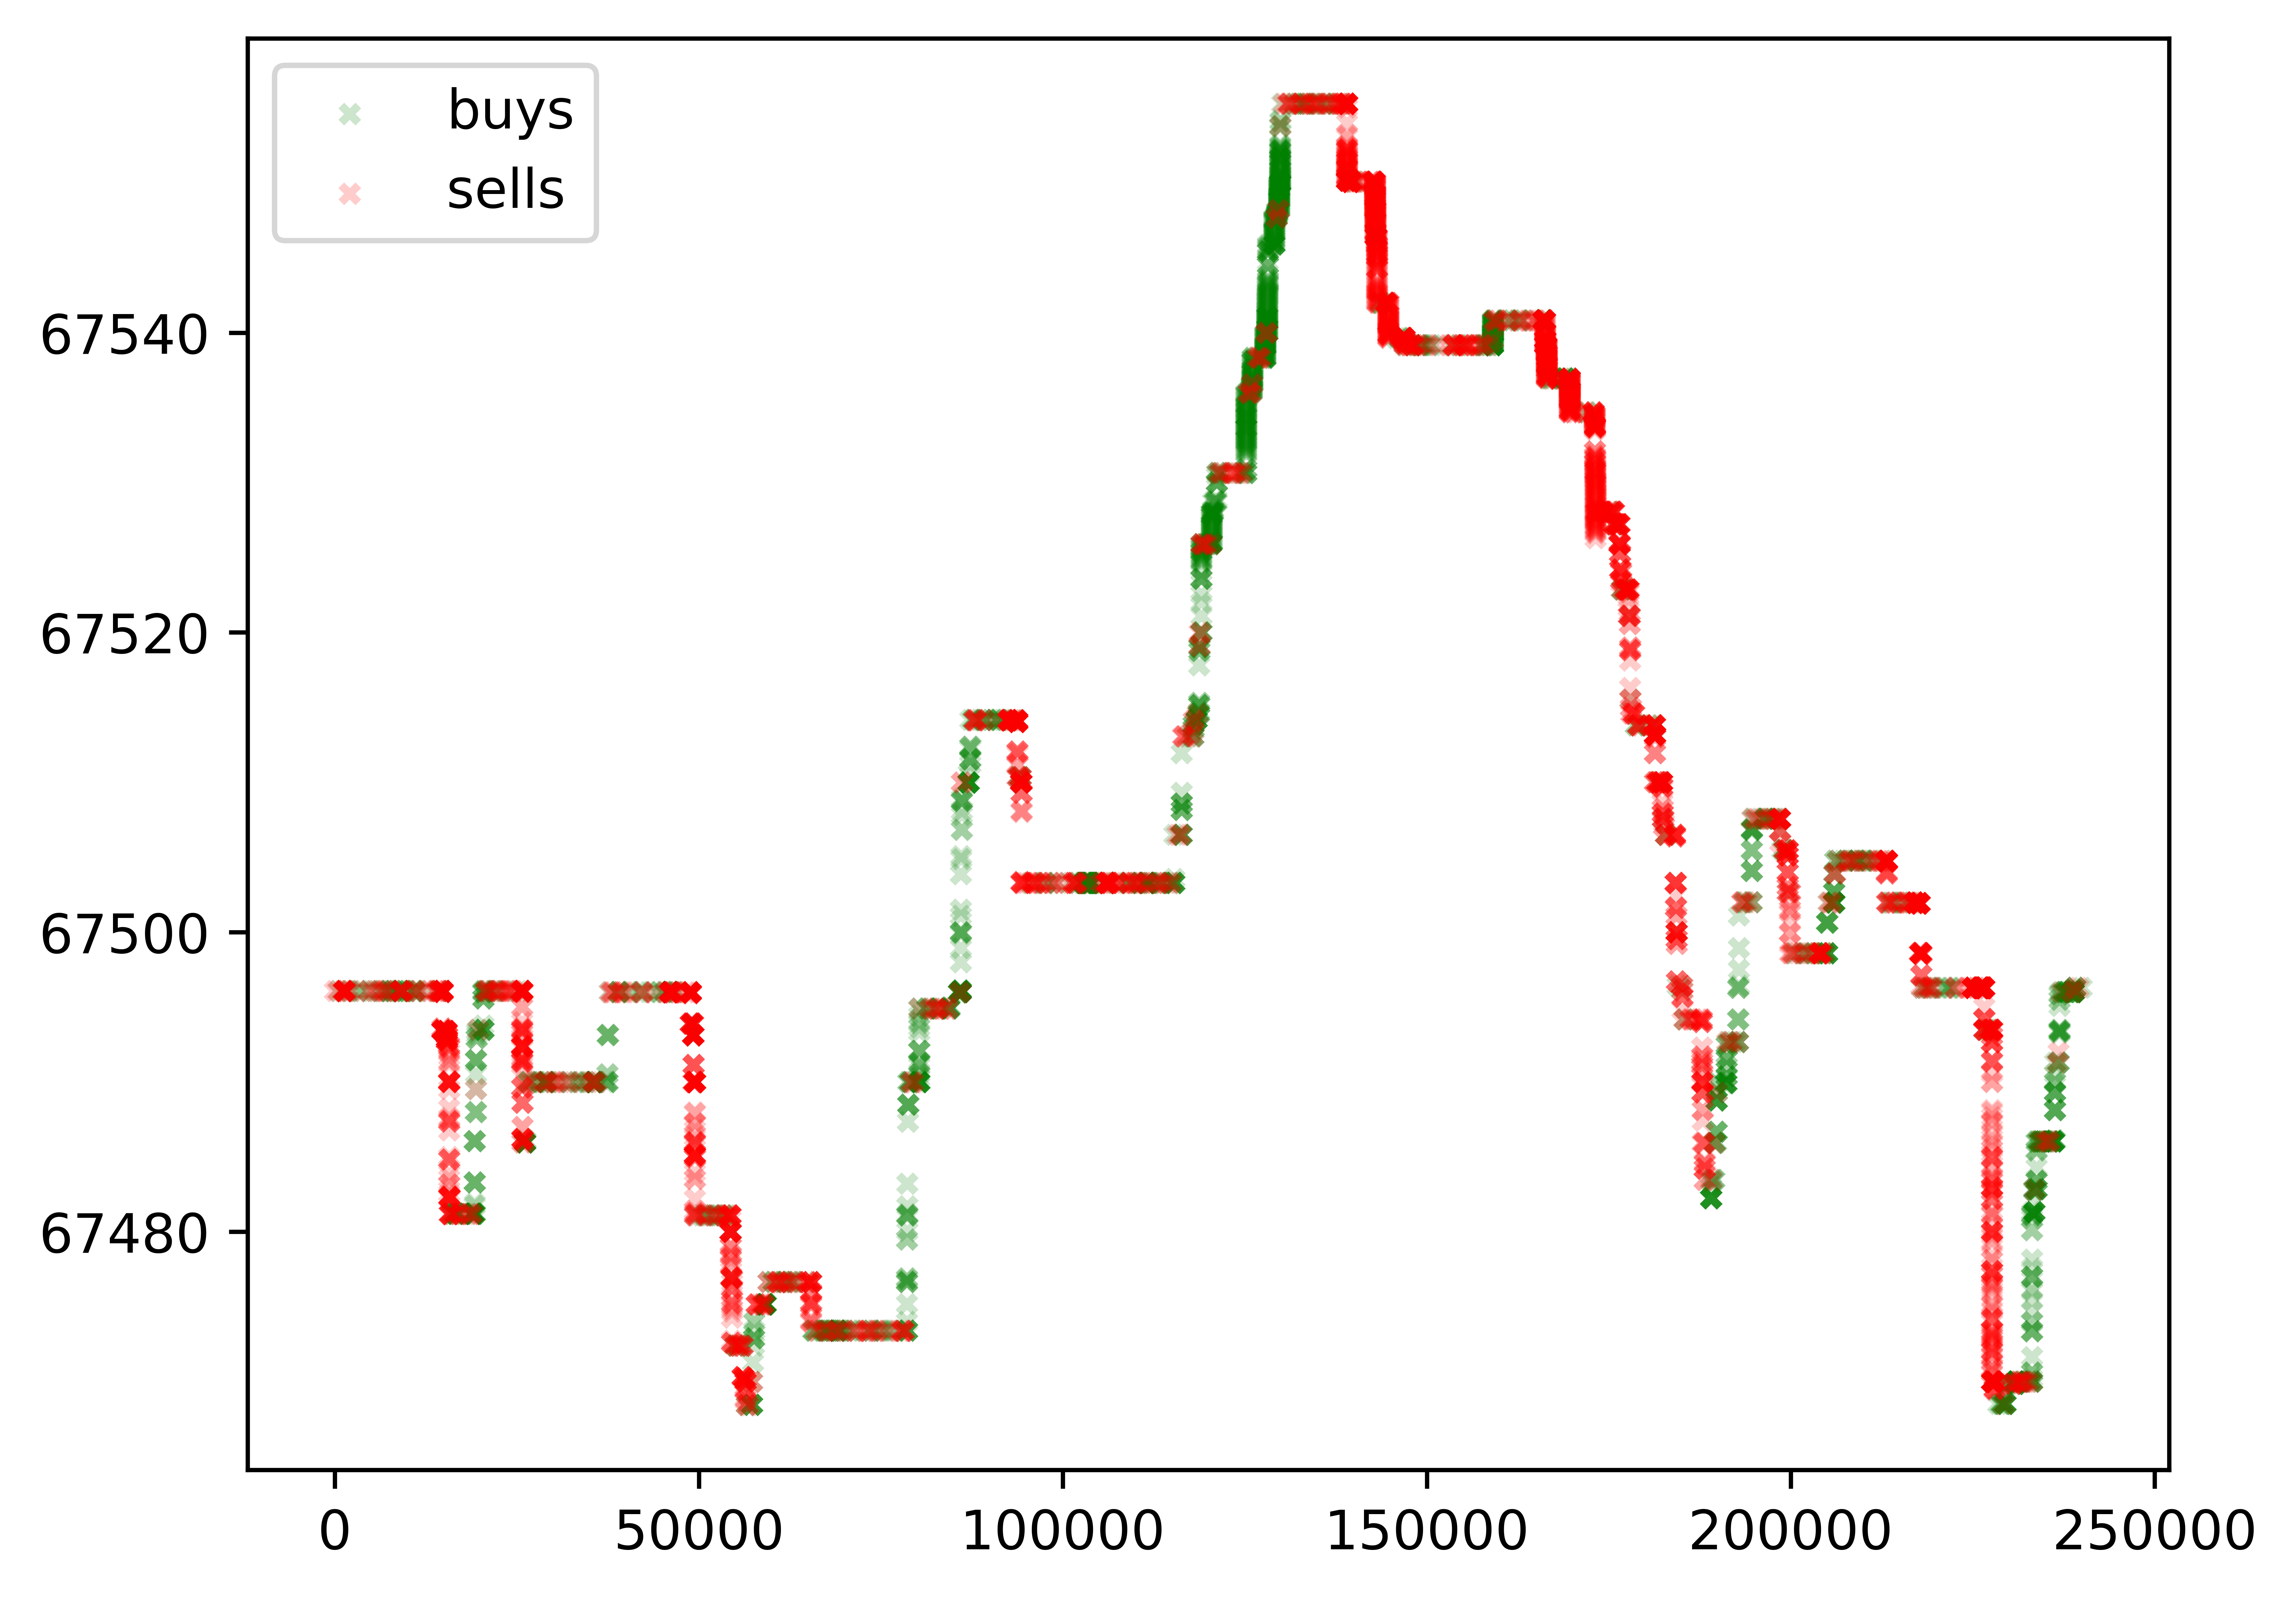

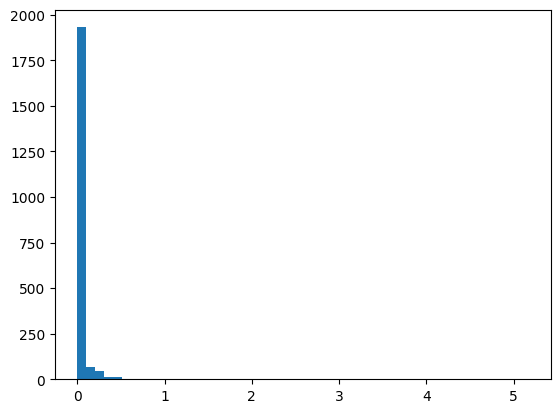

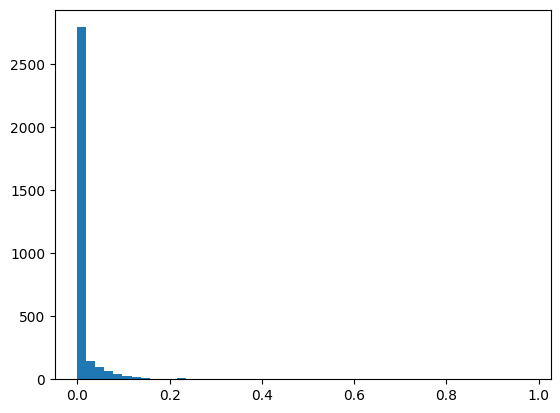

1.00003782613123


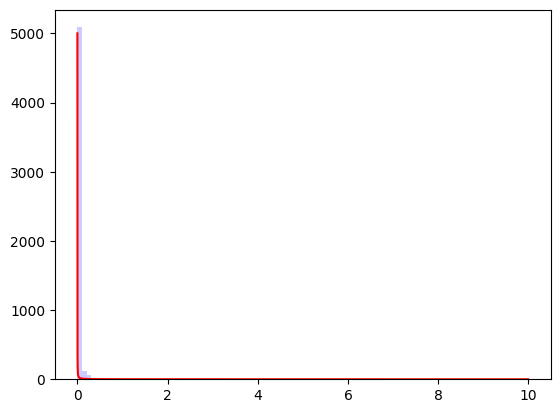

In [8]:
# trade analysis
with open("./data/trades.json", "r") as f:
    data = json.load(f)

trades = data["trades"]
buys = []
sells = []
orders = []

for trade in trades:
    orders.append([int(trade["time"]), float(trade["price"]), float(trade["quantity"])])
    if trade["buyer maker"] == False:
        buys.append([int(trade["time"]), float(trade["price"]), float(trade["quantity"])])
    else:
        sells.append([int(trade["time"]), float(trade["price"]), float(trade["quantity"])])

buys = np.array(buys)
sells = np.array(sells)
orders = np.array(orders)

start = int(np.min(orders[:,0]))
sells[:,0]=sells[:,0]-start
buys[:,0]=buys[:,0]-start
orders[:,0]=orders[:,0]-start

plt.figure(dpi=1200)
plt.scatter(x=buys[:,0], y=buys[:,1], s=10, c='g', marker="x", label='buys',alpha=0.2)
plt.scatter(x=sells[:,0],y=sells[:,1], s=10, c='r', marker="x", label='sells',alpha=0.2)
plt.legend(loc='upper left')
plt.show()

plt.hist(buys[:,2],bins=50)
plt.show()

plt.hist(sells[:,2], bins=50)
plt.show()

# parameter estimation
n = len(orders)
min = np.min(orders[:,2])
a_hat = 1
sum=0
for order in orders:
    sum += np.log(order[2]/min)

a_hat += 1/sum

print(a_hat)

xs = np.linspace(0,10,50000)
with np.errstate(divide='ignore'):
    ys = xs**(-1 * a_hat)

plt.hist(orders[:,2], bins=50,alpha=0.2,color="blue")
plt.plot(xs,ys,c="red")
plt.show()
